In [1]:
%matplotlib inline
########## DISABLE GPU
import os
import sys

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ["LD_LIBRARY_PATH"] = "/usr/local/cuda/lib64"
sys.path.append("../vsegmenter")

import numpy as np
import tensorflow as tf
from eval.run_eval import load_model
from data.dataset import Dataset
from vsegmenter import cfg
from matplotlib import pyplot as plt

cfg.configLog()

import logging

In [2]:
def plot_images(sample, ax = None):
    if ax is None:
        fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(10,20))
    
    ax[0].matshow(sample["image"]); ax[0].set_title(sample["filename"]); ax[0].axis('off')
    ax[1].matshow((sample["mask"]*255).astype(np.uint8), cmap="gray", vmin=0, vmax=255)
    ax[1].set_title(f"Extraction {sample['extraction']}"); ax[1].axis('off')
    ax[2].matshow((sample["prediction"]*255), cmap="gray", vmin=0, vmax=255) 
    ax[2].set_title(f"Predicted Mask {sample['count']}"); ax[2].axis('off')
    
    
    

In [3]:
version = "v5"
model_label = "unet"
img_size = 128

dataset_file = cfg.dataset(f'{version}/dataset_{img_size}.pickle')
x_train, y_train, x_val, y_val = Dataset.load_from_file(dataset_file)

# x_val = x_val[:20]
# y_val = y_val[:20]
x_val = x_train
y_val = y_train

print(f"Num samples: {len(y_val)}")


2023-04-25 11:09:28 INFO Number of train samples: 1678, test samples = 420
2023-04-25 11:09:28 INFO Sample dimensions: sample: (128, 128, 3) label (mask): (128, 128, 2)
2023-04-25 11:09:28 INFO Original image shape : (1678, 128, 128, 3)


Num samples: 1678


In [4]:
validation_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

model = load_model(cfg.results("unet_v4.model"))

logging.info("Running prediction model.")
y_pred = model.predict(x_val)

logging.info("Prediction sucessfully executed")

2023-04-25 11:09:28.815557: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-25 11:09:28.844202: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-25 11:09:28.844552: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-25 11:09:28.849139: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [5]:
pred_mask = tf.math.argmax(y_pred, axis=-1)
pred_mask = pred_mask[..., np.newaxis]
#pred_mask = y_pred[...,1, np.newaxis]

# detect the problems, get the top-20 images with errors
bg_diff = np.abs( y_pred[:, ..., 1] - y_val[:, ..., 1])
sum_bg_diff_item_wise = np.sum(bg_diff, axis=(1, 2))
ordered = np.argsort(-sum_bg_diff_item_wise)

logging.info(f"Worst samples prepared {sum_bg_diff_item_wise[ordered]}")
logging.info(f"Indexes {ordered}")

2023-04-25 11:09:56 INFO Worst samples prepared [1.5280994e+04 1.3708198e+04 1.3626043e+04 ... 3.3686168e+00 3.2504144e+00
 3.0908868e+00]
2023-04-25 11:09:56 INFO Indexes [ 980 1038 1369 ... 1266  907  879]


In [6]:
top_ordered = ordered[:100]
# get original image files
dts = Dataset(os.path.dirname(dataset_file))
lst = dts.get_samples_info_by_idx(top_ordered, test=False)
for i, index in enumerate(top_ordered):
    lst[i]["index"] = index
    lst[i]["prediction"] = pred_mask[index][..., 0]
    lst[i]["count"] = {sum_bg_diff_item_wise[index]}



2023-04-25 11:09:58 INFO Appending extraction info to samples


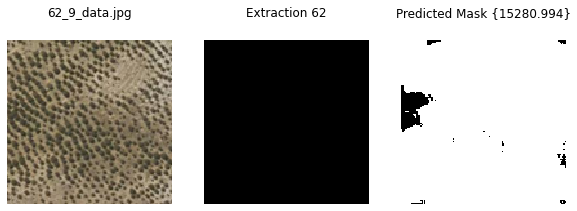

In [7]:
sample_indx = 0
sample1 = lst[sample_indx]
idx = top_ordered[sample_indx]
bg_diff = np.abs(y_val[idx,..., 1]- y_pred[idx, ..., 1])

plot_images(sample1)


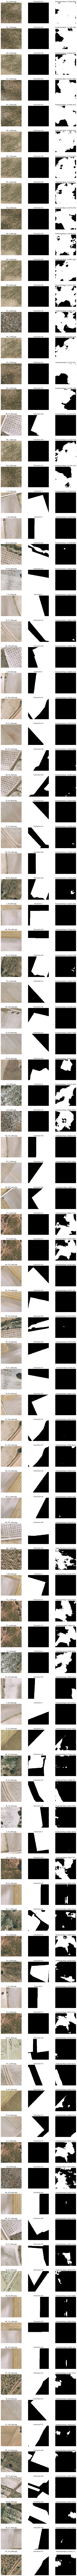

In [8]:
num_images = len(lst)
# crear la figura para mostrar las imágenes
fig, ax = plt.subplots(num_images, 3, sharex=True, sharey=True, figsize=(10,int(num_images*3)))

# iterar sobre las imágenes seleccionadas y mostrar las imágenes y las máscaras originales y predichas
for i in range(num_images):
    sample = lst[i]
    plot_images(sample, ax[i])
# ajustar el diseño de las imágenes en la figura
plt.tight_layout()

In [9]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.cluster import KMeans
from skimage.transform import resize
from tensorflow.python.keras import backend as K


new_size = (224,224)
worst_images = x_val[top_ordered,...]
resized_images = np.zeros((worst_images.shape[0], *new_size, 3))
for i in range(worst_images.shape[0]):
    resized_images[i] = resize(worst_images[i], new_size)


K.clear_session()
tf.keras.backend.clear_session()

    
# Extraer las características de las imágenes
model = ResNet50(weights='imagenet', include_top=True)
logging.info(f"Extracting image features {len(worst_images)}")
features = model.predict(resized_images)
logging.info(f"Finished {features.shape}")


2023-04-25 11:11:09 INFO Extracting image features 100
2023-04-25 11:11:11 INFO Finished (100, 1000)


In [10]:
# Aplicar clustering K-means
kmeans = KMeans(n_clusters=5, random_state=0).fit(features)

# Obtener las etiquetas de clustering
labels = kmeans.labels_

# Imprimir las etiquetas de cada imagen
clusters = {}
image_labels = []
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(i)
    image_labels.append(label)


In [11]:
def plot_cluster(images, max_images=30):
    num_images = min(len(images),max_images)
    # crear la figura para mostrar las imágenes
    fig, ax = plt.subplots(num_images, 3, sharex=True, sharey=True, figsize=(10,int(num_images*3)))    
    for i,image_idx in enumerate(images[:num_images]):
        # get original image:
        sample = lst[image_idx]
        plot_images(sample, ax[i])

def plot_image_by_id(id):
        sample = lst[id]
        plot_images(sample)
            

2023-04-25 11:11:13 WARNING Detecting that an object or model or tf.train.Checkpoint is being deleted with unrestored values. See the following logs for the specific values in question. To silence these warnings, use `status.expect_partial()`. See https://www.tensorflow.org/api_docs/python/tf/train/Checkpoint#restorefor details about the status object returned by the restore function.


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer.iter


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer.beta_1


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer.beta_2


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer.decay


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer.learning_rate


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.total


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.0.count


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.total


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.1.count


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.2.total


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.2.count


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.3.total


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).keras_api.metrics.3.count


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).layer_with_weights-13.kernel


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).layer_with_weights-13.bias


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.0


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.1


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.2


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.3


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.4


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.5


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.6


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.7


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.8


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.9


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.10


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.11


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.12


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.13


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.14


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.15


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.16


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.17


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.18


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.19


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.20


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.21


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.22


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.23


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.24


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.25


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.26


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.27


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.28


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.29


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.30


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.31


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.32


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.33


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.34


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.35


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.36


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.37


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.38


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.39


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.40


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.41


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.42


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'm' for (root).variables.43


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).layer_with_weights-13.kernel


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).layer_with_weights-13.bias


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.0


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.1


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.2


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.3


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.4


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.5


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.6


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.7


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.8


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.9


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.10


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.11


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.12


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.13


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.14


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.15


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.16


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.17


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.18


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.19


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.20


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.21


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.22


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.23


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.24


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.25


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.26


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.27


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.28


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.29


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.30


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.31


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.32


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.33


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.34


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.35


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.36


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.37


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.38


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.39


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.40


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.41


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.42


2023-04-25 11:11:13 WARNING Value in checkpoint could not be found in the restored object: (root).optimizer's state 'v' for (root).variables.43


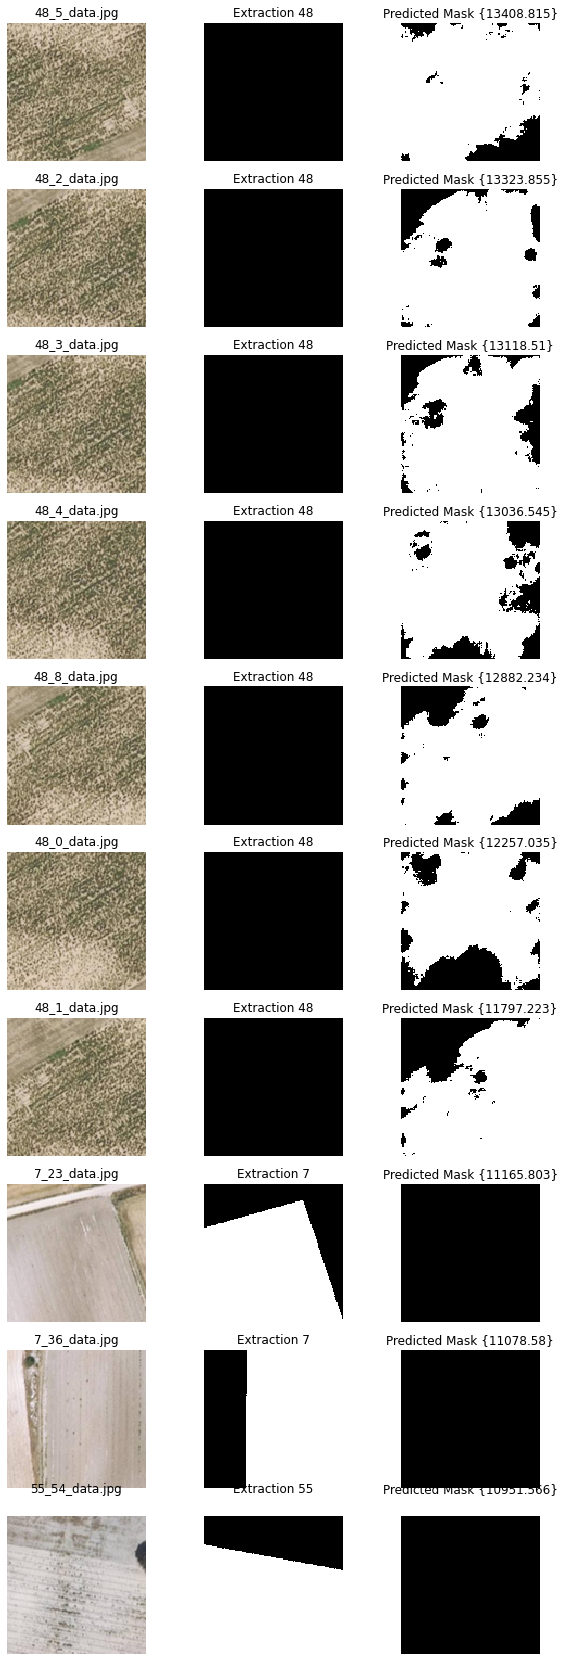

In [12]:
plot_cluster(clusters[0], max_images=10)

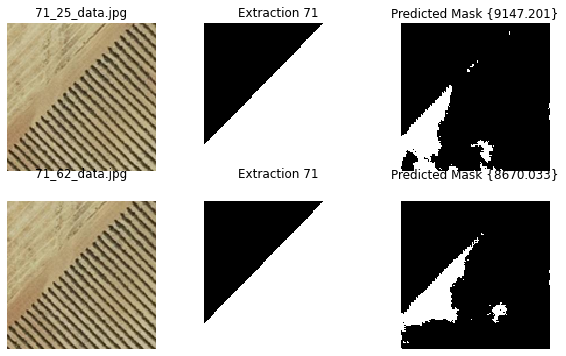

In [13]:
plot_cluster(clusters[1], max_images=10)

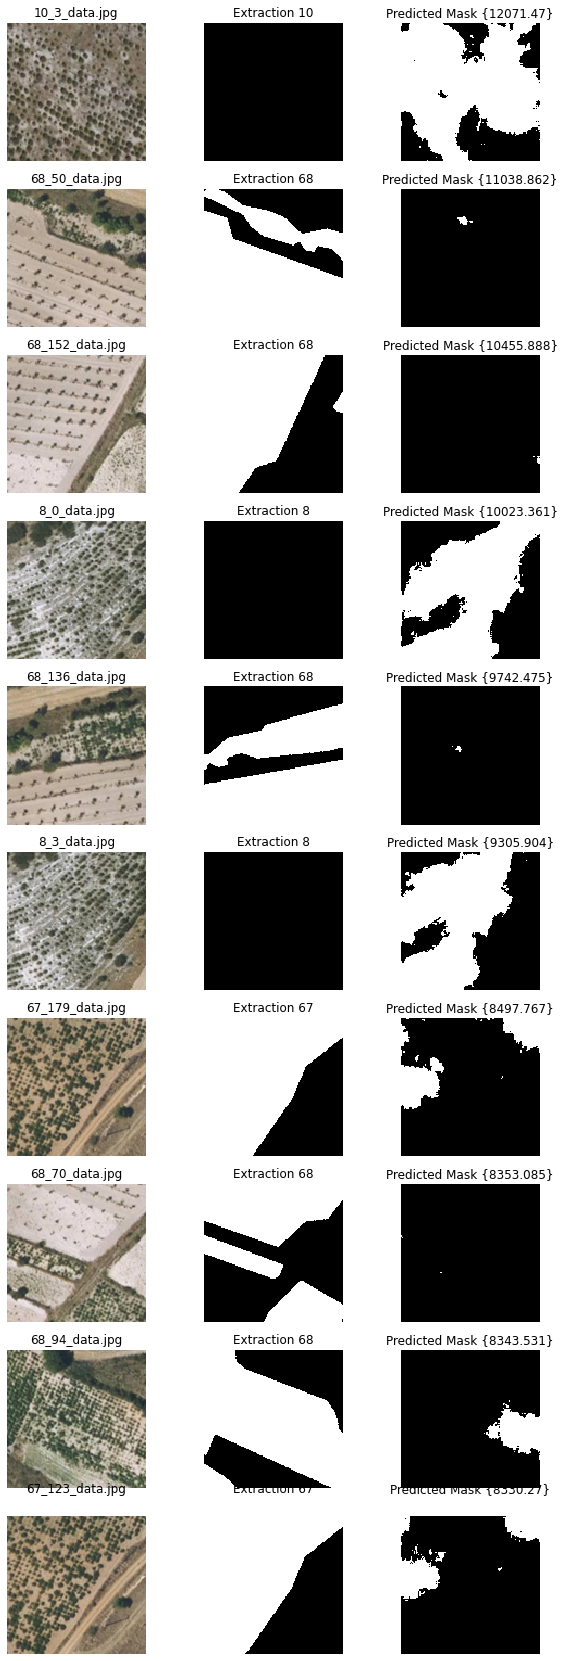

In [14]:
plot_cluster(clusters[2], max_images=20)

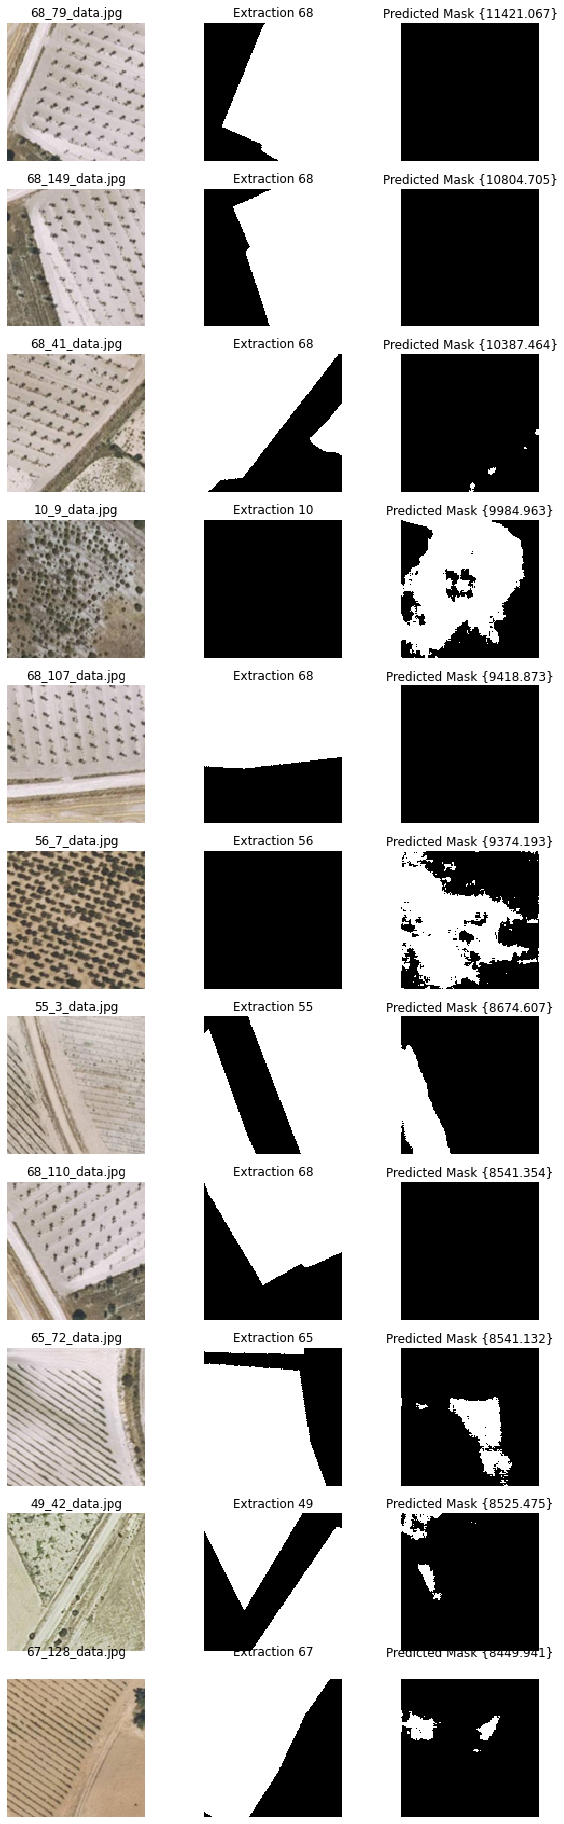

In [15]:
plot_cluster(clusters[3], max_images=20)

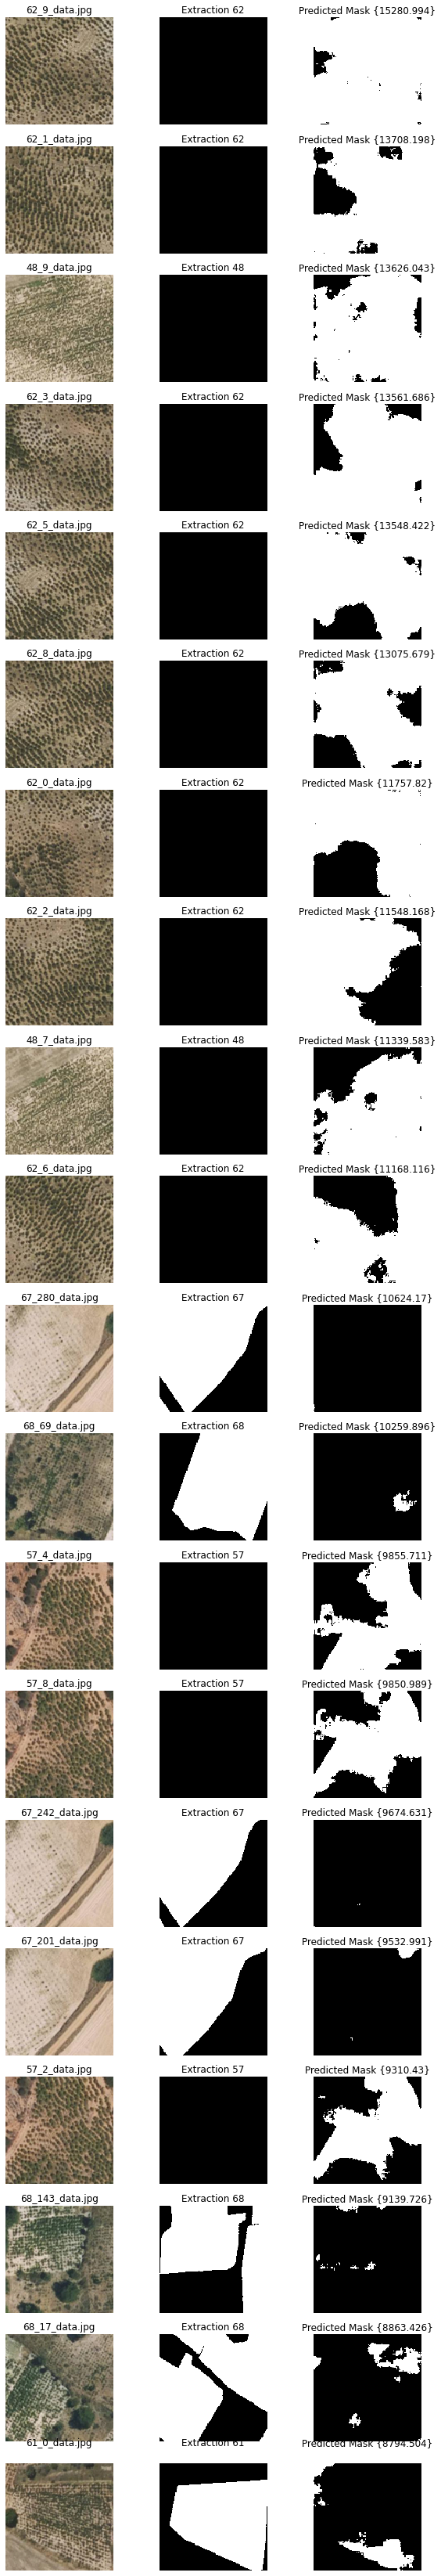

In [16]:
plot_cluster(clusters[4], max_images=20)

In [17]:
# Calculate optimal number of clusters
sse = []
for num_clusters in range(1, 25):
    model = KMeans(n_clusters=num_clusters, random_state=0).fit(features)
    sse.append(model.inertia_)

In [18]:
sse

[0.005033266730606556,
 0.0026937229558825493,
 0.0016606877325102687,
 0.0012580652255564928,
 0.0010204619029536843,
 0.0008486962178722024,
 0.0006801454583182931,
 0.000589553324971348,
 0.0004987030406482518,
 0.0004520929360296577,
 0.00042433952330611646,
 0.0004011971177533269,
 0.0003738693776540458,
 0.0003497221041470766,
 0.00032456539338454604,
 0.0002993264643009752,
 0.0002739580813795328,
 0.0002547727490309626,
 0.00024327622668351978,
 0.00023327361850533634,
 0.00022002488549333066,
 0.0002124395832652226,
 0.00019583720131777227,
 0.00018439770792610943]

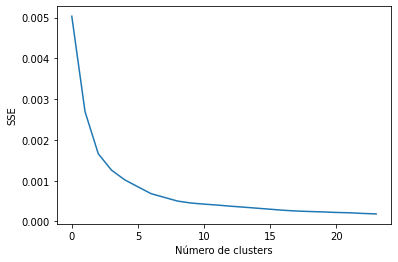

In [19]:
plt.plot(range(len(sse)), sse)
plt.xlabel('Número de clusters')
plt.ylabel('SSE')
plt.show()

In [20]:
image_labels

[4,
 4,
 4,
 4,
 4,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 2,
 0,
 4,
 4,
 3,
 4,
 4,
 0,
 0,
 2,
 0,
 0,
 0,
 3,
 0,
 4,
 0,
 2,
 3,
 0,
 0,
 0,
 4,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 2,
 3,
 0,
 0,
 0,
 4,
 4,
 0,
 0,
 2,
 0,
 0,
 0,
 4,
 4,
 0,
 0,
 3,
 3,
 0,
 0,
 4,
 2,
 0,
 0,
 1,
 4,
 0,
 0,
 0,
 0,
 0,
 4,
 0,
 4,
 0,
 0,
 0,
 3,
 1,
 0,
 0,
 4,
 0,
 3,
 3,
 3,
 0,
 0,
 0,
 2,
 0,
 3,
 4,
 2,
 2,
 0,
 2]

/media/gus/workspace/wpy/venvs/basictf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/media/gus/workspace/wpy/venvs/basictf/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


AttributeError: module 'keras.api._v2.keras.preprocessing.image' has no attribute 'shape'

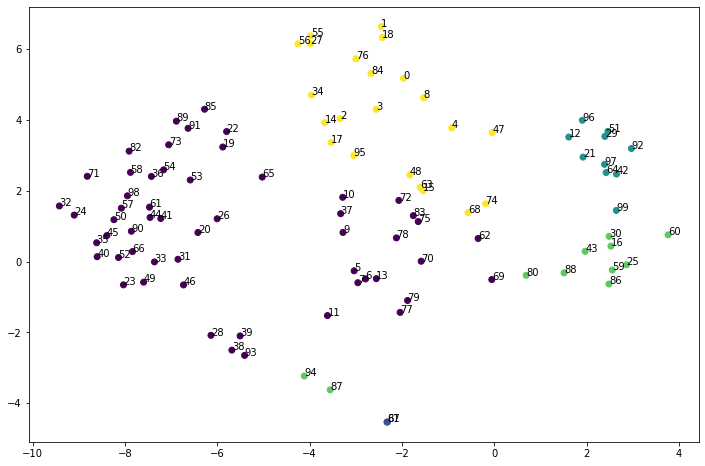

In [21]:
from sklearn.manifold import TSNE

# Project features using tSNE
# Aplicar t-SNE
tsne = TSNE(n_components=2)
projected_features = tsne.fit_transform(features.reshape(features.shape[0], -1))

# Graficar los puntos proyectados
# plt.scatter(projected_features[:, 0], projected_features[:, 1])
# plt.show()


# Crea la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 8))

# Grafica los puntos en la proyección TSNE y agrega una etiqueta para cada punto
scatter = ax.scatter(projected_features[:,0], projected_features[:,1], c=image_labels)

# Recorre todos los puntos y agrega el ID de la imagen en su ubicación
for i, txt in enumerate(range(len(image_labels))):
    ax.annotate(txt, (projected_features[i,0], projected_features[i,1]))

for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        text = ax.text(j, i, image[i, j], ha="center", va="center", color="w")
 

# Agrega una barra de color para mostrar los índices correspondientes a los puntos
colorbar = plt.colorbar(scatter)

# Define la función que muestra la imagen correspondiente cuando haces clic en un punto
def on_click(event):
#     if event.inaxes == ax:
    index = int(event.ind[0])
#         image = images[index] 
    image = lst[index]
    print("asdfasfas")
    plt.figure()
    plt.imshow(image)
    plt.show()

# Agrega la función de clic a la figura
fig.canvas.mpl_connect('button_press_event', on_click)

# Muestra la figura
plt.show()


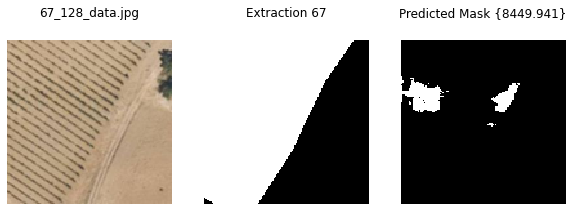

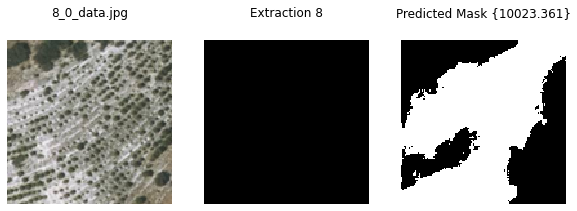

In [24]:

plot_image_by_id(94)
plot_image_by_id(42)
